In [9]:
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path
notebook_dir = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_dir, '../..'))
sys.path.append(project_root)

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices: ", tf.config.list_physical_devices('GPU'))

# Enable memory growth for GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print(f'Memory growth enabled for device: {device}')

Num GPUs Available:  0
GPU Devices:  []


In [10]:
from src.data.dataset_loader import WasteDatasetLoader
from src.data.preprocessing import DataPreprocessor
from src.models.model import WasteClassifier

# Load and preprocess data
loader = WasteDatasetLoader()
preprocessor = DataPreprocessor()

# Get TrashNet data
print("Loading TrashNet dataset...")
images, labels = loader.load_trashnet()
processed_images, processed_labels = preprocessor.preprocess_images(images, labels)
data_splits = preprocessor.create_train_val_test_split(processed_images, processed_labels)

Loading TrashNet dataset...
Loading TrashNet dataset...


In [11]:
# Initialize training strategy
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Initialize model
    classifier = WasteClassifier()
    model = classifier.build_model()
    
    # Train model
    history = classifier.train(
        train_data=data_splits['train'],
        validation_data=data_splits['val'],
        epochs=20,
        batch_size=32
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 96s 785ms/step - accuracy: 0.1950 - loss: 1.8876 - val_accuracy: 0.2282 - val_loss: 1.7925
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.2079 - loss: 1.8268 - val_accuracy: 0.2678 - val_loss: 1.7683
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2600 - loss: 1.7394 - val_accuracy: 0.2770 - val_loss: 1.6713
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.2994 - loss: 1.6418 - val_accuracy: 0.3536 - val_loss: 1.5300
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 75s 662ms/step - accuracy: 0.3365 - loss: 1.5544 - val_accuracy: 0.3760 - val_loss: 1.4896
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.3238 - loss: 1.5355 - val_accuracy: 0.2982 - val_loss: 1.5805
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 109s 968ms/step - accuracy: 0.3767 - loss: 1.4803 - val_accuracy: 0.3734 - val_

In [12]:
print("\nLoading COCO dataset for evaluation...")
coco_images, coco_labels = loader.load_coco()
processed_coco_images, processed_coco_labels = preprocessor.preprocess_images(
    coco_images, coco_labels, augment=False
)


Loading COCO dataset for evaluation...
Loading COCO dataset...
loading annotations into memory...
Done (t=10.76s)
creating index...
index created!


In [13]:
print("\nEvaluating model on COCO dataset...")
coco_results = classifier.evaluate_on_coco((processed_coco_images, processed_coco_labels))


Evaluating model on COCO dataset...
153/153 ━━━━━━━━━━━━━━━━━━━━ 129s 823ms/step - accuracy: 0.0106 - loss: 4.6376


TrashNet Test Set Evaluation:
Test accuracy: 0.4875
Test loss: 1.2600
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step 

Detailed Classification Report:
              precision    recall  f1-score   support

       glass       0.56      0.34      0.43       166
       paper       0.38      0.73      0.50       167
   cardboard       0.54      0.41      0.46       130
     plastic       0.54      0.58      0.56       132
       metal       0.67      0.50      0.57       118
       trash       0.50      0.07      0.12        46

    accuracy                           0.49       759
   macro avg       0.53      0.44      0.44       759
weighted avg       0.53      0.49      0.47       759



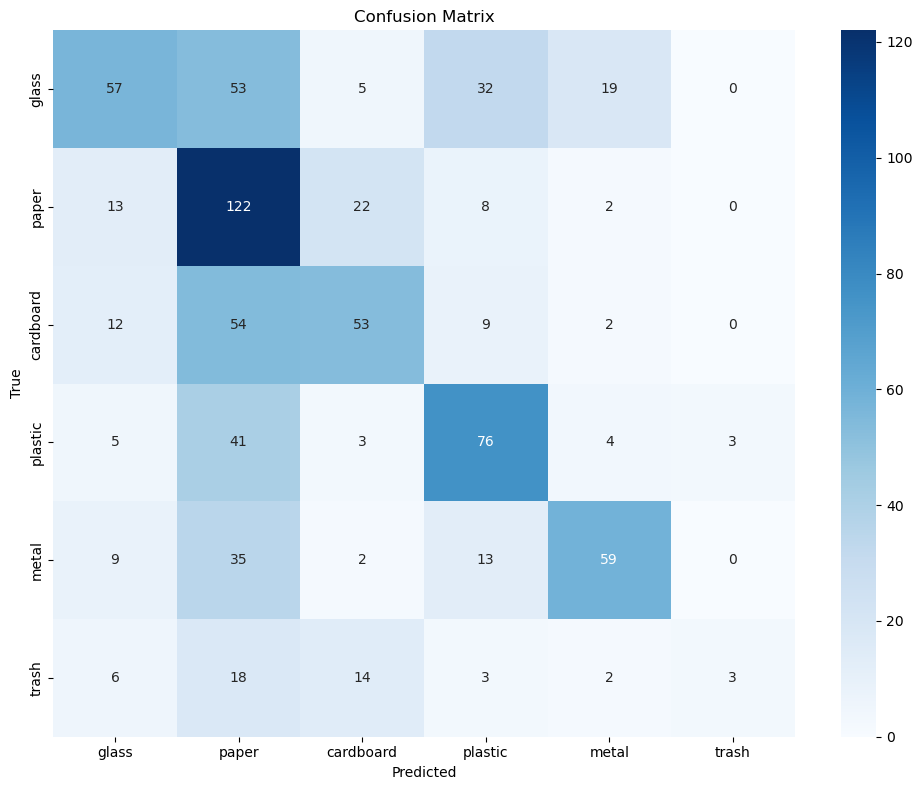


COCO Dataset Evaluation:
COCO accuracy: 0.0100
COCO loss: 4.6351


In [14]:
# Add evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on TrashNet test set
print("TrashNet Test Set Evaluation:")
test_loss, test_acc = classifier.model.evaluate(
    data_splits['test'][0], 
    data_splits['test'][1], 
    verbose=0
)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get predictions
y_pred = classifier.model.predict(data_splits['test'][0])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = data_splits['test'][1]

# Print classification report
print("\nDetailed Classification Report:")
print(classification_report(
    y_true, 
    y_pred_classes, 
    target_names=['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash'],
            yticklabels=['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# COCO dataset evaluation
print("\nCOCO Dataset Evaluation:")
coco_loss, coco_acc = classifier.model.evaluate(
    processed_coco_images,
    processed_coco_labels,
    verbose=0
)
print(f"COCO accuracy: {coco_acc:.4f}")
print(f"COCO loss: {coco_loss:.4f}")

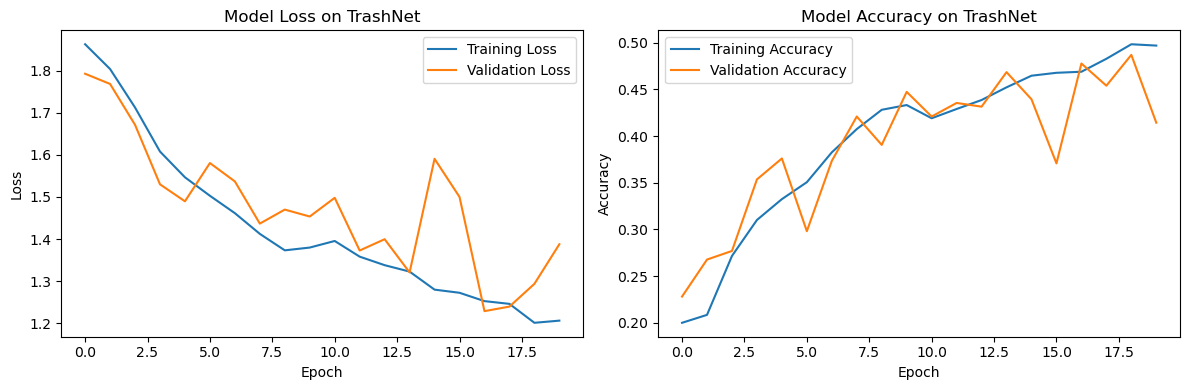


COCO Dataset Evaluation Results:
Test Loss: 4.6351
Test Accuracy: 0.0100


In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss on TrashNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy on TrashNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\nCOCO Dataset Evaluation Results:")
print(f"Test Loss: {coco_results['test_loss']:.4f}")
print(f"Test Accuracy: {coco_results['test_accuracy']:.4f}")

In [17]:
# Create save directory and save model weights
model_save_path = os.path.join(project_root, 'models', 'saved_models')
os.makedirs(model_save_path, exist_ok=True)

# Save model weights with correct file extension
weights_path = os.path.join(model_save_path, 'waste_classifier.weights.h5')
classifier.model.save_weights(weights_path)
print(f"Model weights saved to: {weights_path}")

# save complete model for reference later
model_path = os.path.join(model_save_path, 'waste_classifier_full.keras')
classifier.model.save(model_path)
print(f"Full model saved to: {model_path}")

Model weights saved to: c:\Users\aondo\OneDrive\Documents\semester three fanshawe college\INFO 6156 Capstone Project\main_project\models\saved_models\waste_classifier.weights.h5
Full model saved to: c:\Users\aondo\OneDrive\Documents\semester three fanshawe college\INFO 6156 Capstone Project\main_project\models\saved_models\waste_classifier_full.keras
